In [49]:
import matplotlib.pyplot as plt

import torch as tc
import torch.nn as nn
import torch.optim as optim
from torchmetrics.regression import MeanAbsolutePercentageError

from tqdm import tqdm

from sklearn.datasets import make_friedman1
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error


In [50]:
# Generate dataset and normalize it

X, y = make_friedman1(n_samples=150_000, n_features=10, random_state=42)

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel() 

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (150000, 10)
y shape: (150000,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

array([[-1.12844861, -1.00599231, -0.41721756, ..., -1.69863766,
        -0.34392992,  0.18905258],
       [ 0.88337365, -1.44972988,  1.43238364, ..., -0.2154109 ,
        -0.83460073,  0.05776972],
       [ 0.53960936, -0.25142776, -0.87622764, ..., -0.478134  ,
        -0.77140058, -0.03587554],
       ...,
       [-0.99115874,  0.12010404, -0.7387298 , ..., -0.26921482,
        -1.39318052,  0.97179254],
       [ 0.99925473, -1.56530701, -1.34817018, ...,  1.39148448,
        -0.32280283, -1.21406862],
       [-0.68922807, -0.84375007,  0.62200066, ..., -1.00389827,
        -0.40597488, -1.28684516]], shape=(120000, 10))

In [52]:
# Fit data into LR
reg = LinearRegression().fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

# Compute metrics for LR
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print Metrics
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")

Train MSE: 0.2480, Test MSE: 0.2482
Train R²: 0.7521, Test R²: 0.7513
Train MAPE: 11.1481, Test MAPE: 2.8284


In [53]:
# Define the architecture of a DNN

class DNN(nn.Module):
    def __init__(self, input_dim, layers_dim):
        
        super(DNN, self).__init__()

        layers = []

        dim = input_dim

        for hidden_dim in layers_dim:
            layers.append(nn.Linear(dim, hidden_dim))
            layers.append(nn.ReLU())
            dim = hidden_dim

        layers.append(nn.Linear(dim, 1))  
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [54]:
# Convert test and train sets to PyTorch tensors

X_train = tc.tensor(X_train, dtype=tc.float32)
X_test = tc.tensor(X_test, dtype=tc.float32)
y_train = tc.tensor(y_train, dtype=tc.float32).view(-1, 1)
y_test = tc.tensor(y_test, dtype=tc.float32).view(-1, 1)


In [55]:
# Function to train a DNN model with the given layers, optimizer and learning rate
# Default epoch=10

def train_model(layers, opt_name, lr, epoch=50):

    model = DNN(input_dim=10, layers_dim=layers)

    if opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif opt_name == "RMSProp":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss_function = nn.MSELoss()

    mape = MeanAbsolutePercentageError().float()

    train_mse = []
    train_r2 = []
    train_mape = []

    test_mse = []
    test_r2 = []
    test_mape = []


    for epoch in tqdm(range(epoch), desc=f"Training with num_layers: {len(layers)} optimizer: {opt_name} learning rate: {lr}"):
        model.train()
        optimizer.zero_grad()
        
        y_train_pred = model(X_train)
        loss = loss_function(y_train_pred, y_train)
        loss.backward()

        tc.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

        optimizer.step()

        train_r2_value = r2_score(y_train.numpy(), y_train_pred.detach().numpy())
        train_mape_value = mape(y_train_pred, y_train).item()
        
        # Evaluate on test set
        model.eval()
        with tc.no_grad():
            
            y_test_pred = model(X_test)

            test_loss = loss_function(y_test_pred, y_test).item()
            test_r2_value = r2_score(y_test.numpy(), y_test_pred.numpy())
            
            test_mape_value = mape(y_test_pred, y_test).item()
        
        # Store metrics
        train_mse.append(loss.item())
        train_r2.append(train_r2_value)
        train_mape.append(train_mape_value)

        test_mse.append(test_loss)
        test_r2.append(test_r2_value)
        test_mape.append(test_mape_value)

    return train_mse, test_mse, train_r2, test_r2, train_mape, test_mape

In [56]:
# Train DNN model and store results

layer_configs = [[32], [32]*5, [32]*25]  
optimizers = ["SGD", "RMSProp", "Adam"]
learning_rates = [0.1, 0.01, 0.001]

results = {}

# Iterate over all possible configurations of layers, optimizers, and learning rates
for layers in layer_configs:
    for optimizer in optimizers:
        for lr in learning_rates:
            train_mse, test_mse, train_r2, test_r2, train_mape, test_mape = train_model(layers, optimizer, lr)
            results[(tuple(layers), optimizer, lr)] = (train_mse, test_mse, train_r2, test_r2, train_mape, test_mape)


Training with num_layers: 1 optimizer: SGD learning rate: 0.1: 100%|██████████| 50/50 [00:01<00:00, 39.20it/s]
Training with num_layers: 1 optimizer: SGD learning rate: 0.01: 100%|██████████| 50/50 [00:01<00:00, 45.19it/s]
Training with num_layers: 1 optimizer: SGD learning rate: 0.001: 100%|██████████| 50/50 [00:01<00:00, 48.35it/s]
Training with num_layers: 1 optimizer: RMSProp learning rate: 0.1: 100%|██████████| 50/50 [00:01<00:00, 48.56it/s]
Training with num_layers: 1 optimizer: RMSProp learning rate: 0.01: 100%|██████████| 50/50 [00:01<00:00, 47.03it/s]
Training with num_layers: 1 optimizer: RMSProp learning rate: 0.001: 100%|██████████| 50/50 [00:01<00:00, 48.31it/s]
Training with num_layers: 1 optimizer: Adam learning rate: 0.1: 100%|██████████| 50/50 [00:00<00:00, 50.28it/s]
Training with num_layers: 1 optimizer: Adam learning rate: 0.01: 100%|██████████| 50/50 [00:00<00:00, 51.65it/s]
Training with num_layers: 1 optimizer: Adam learning rate: 0.001: 100%|██████████| 50/50 [0

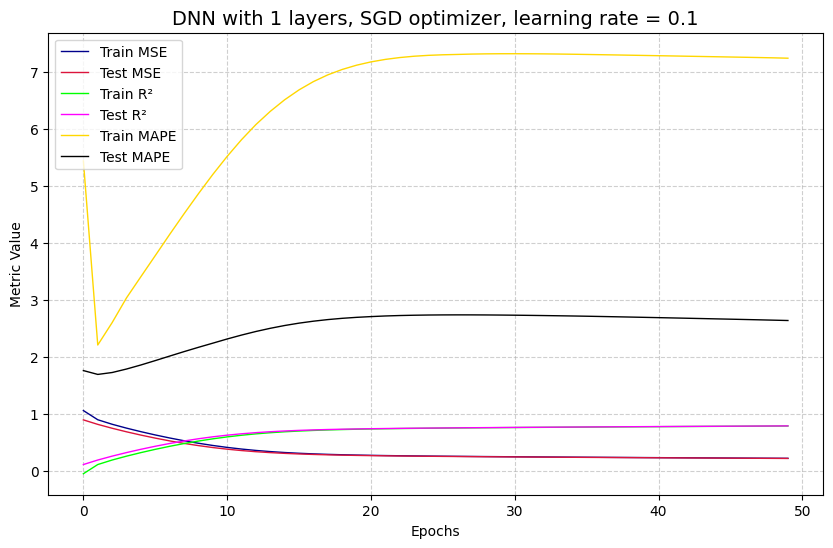

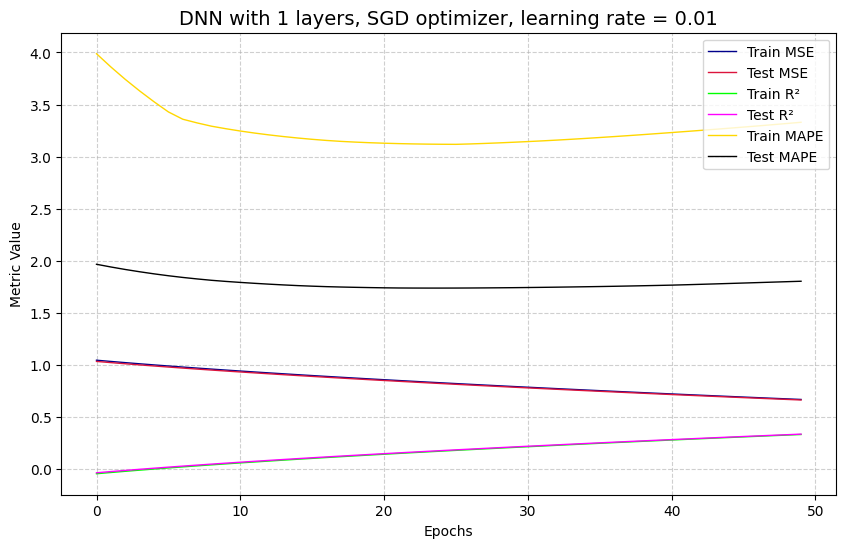

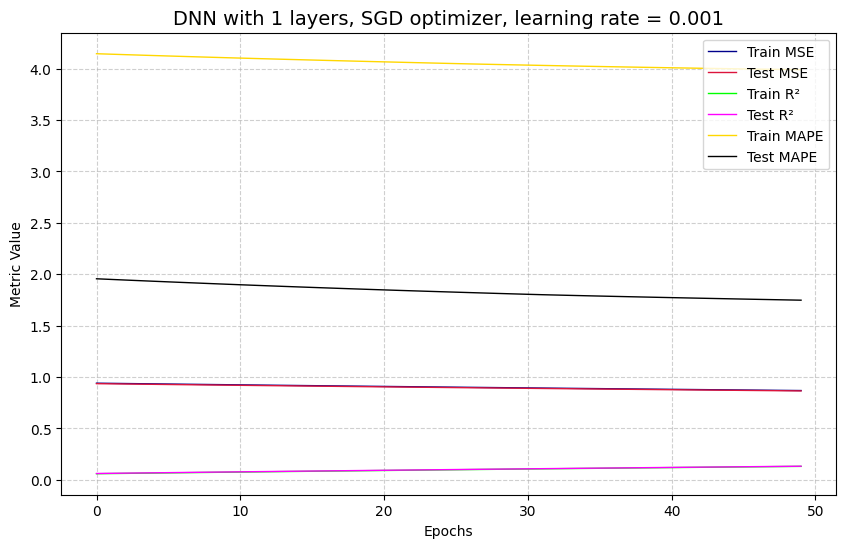

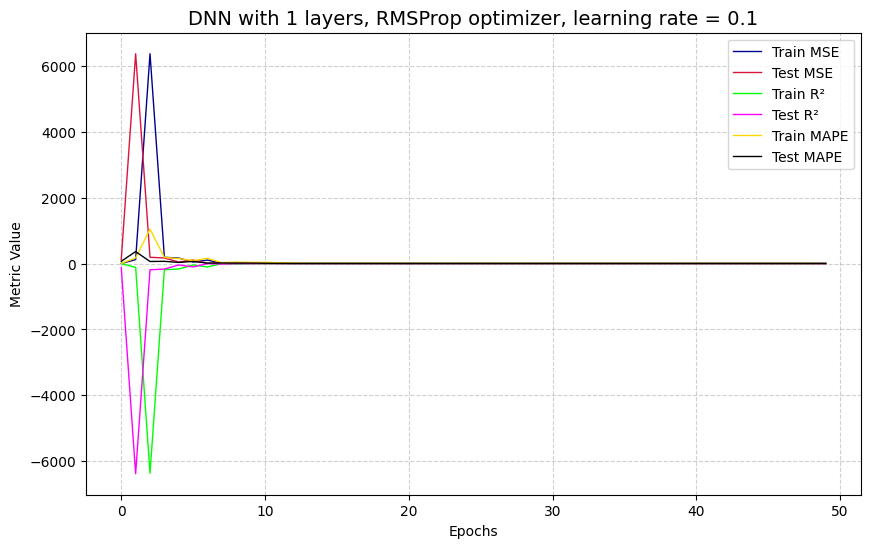

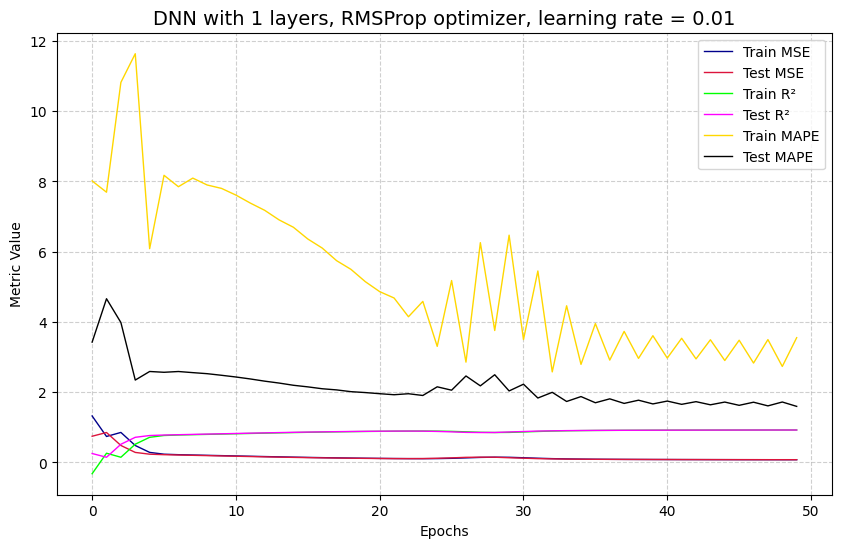

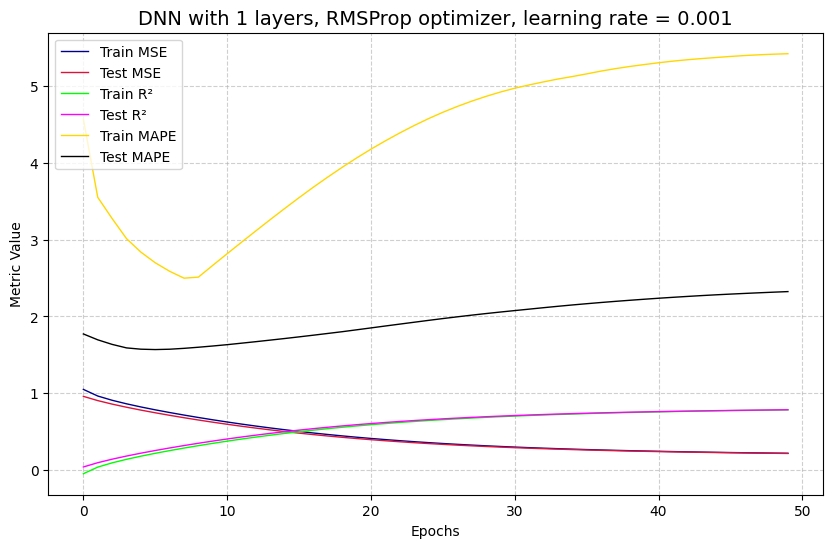

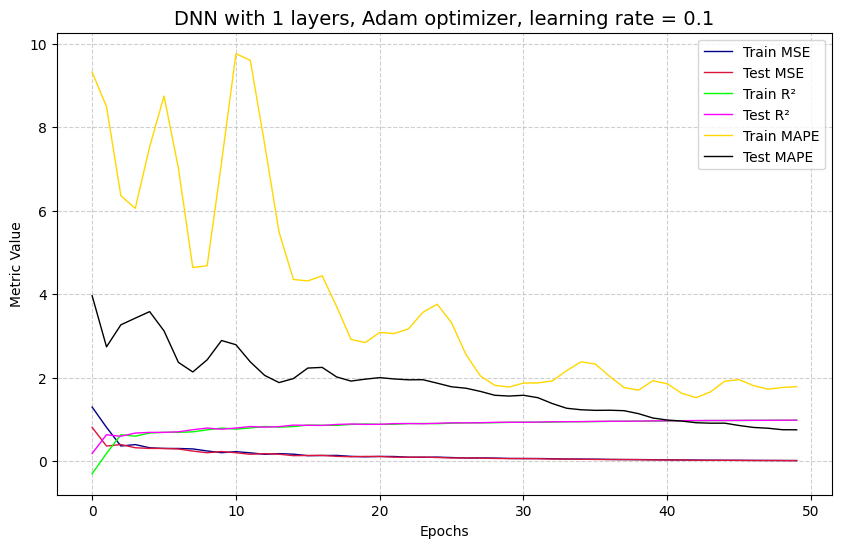

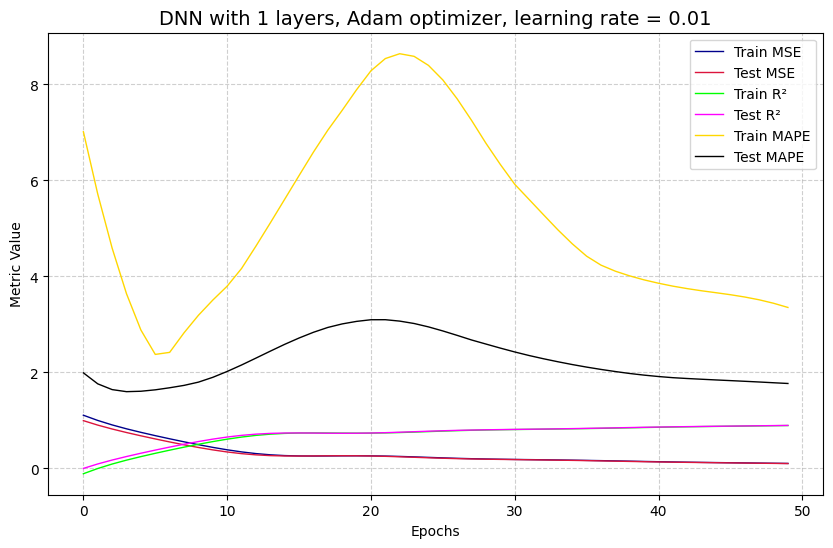

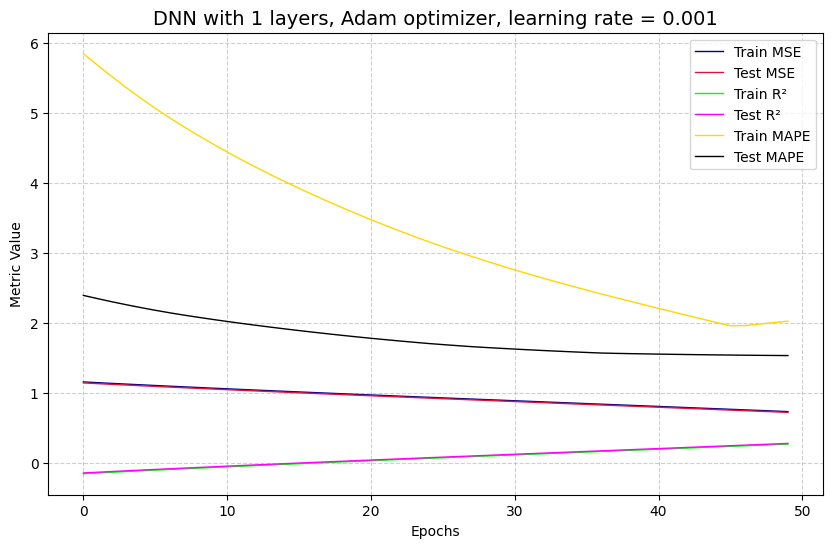

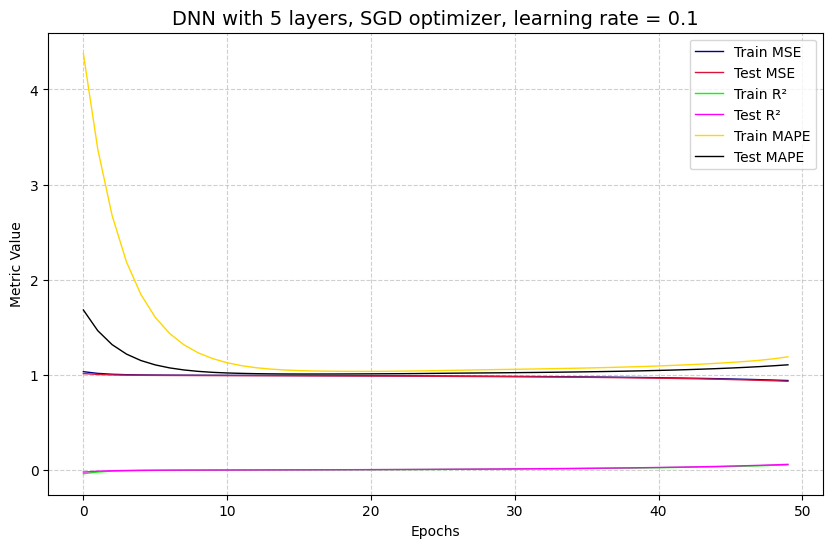

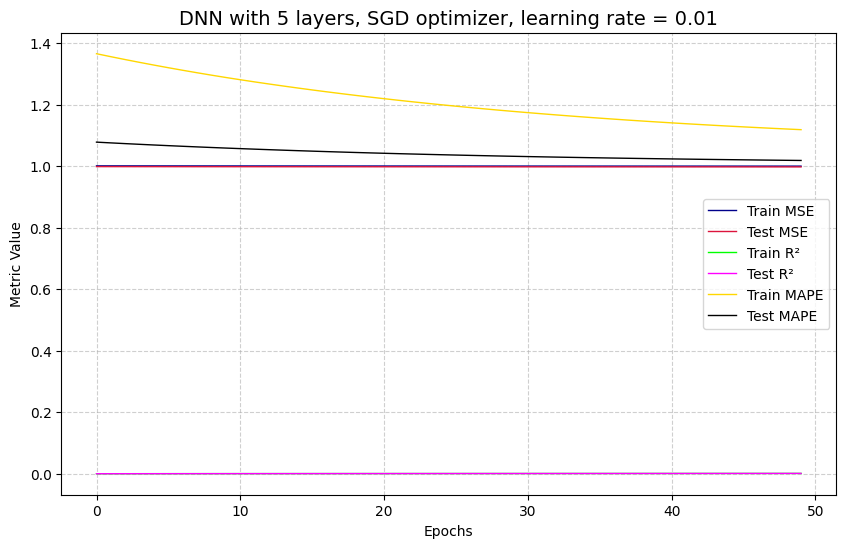

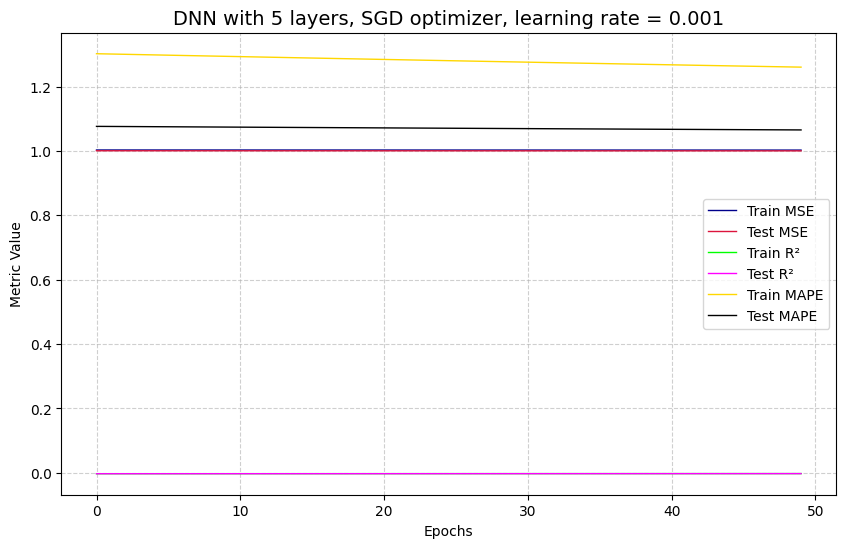

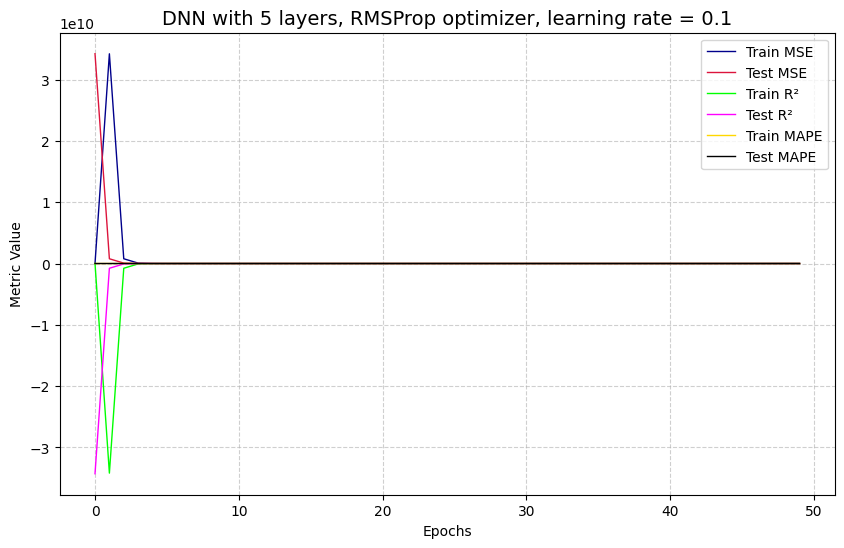

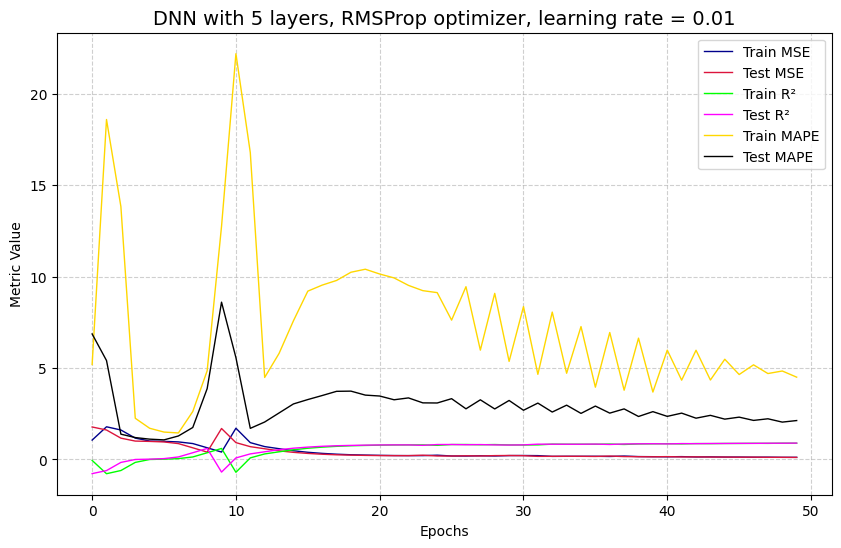

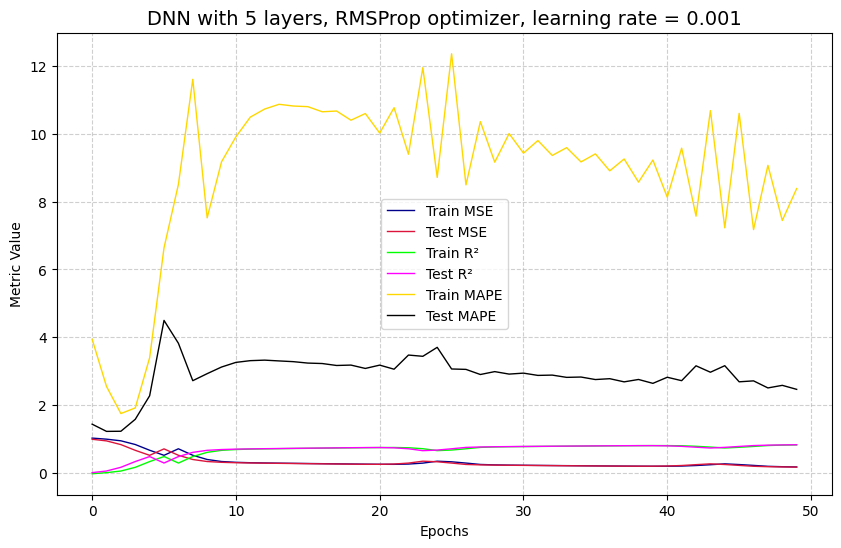

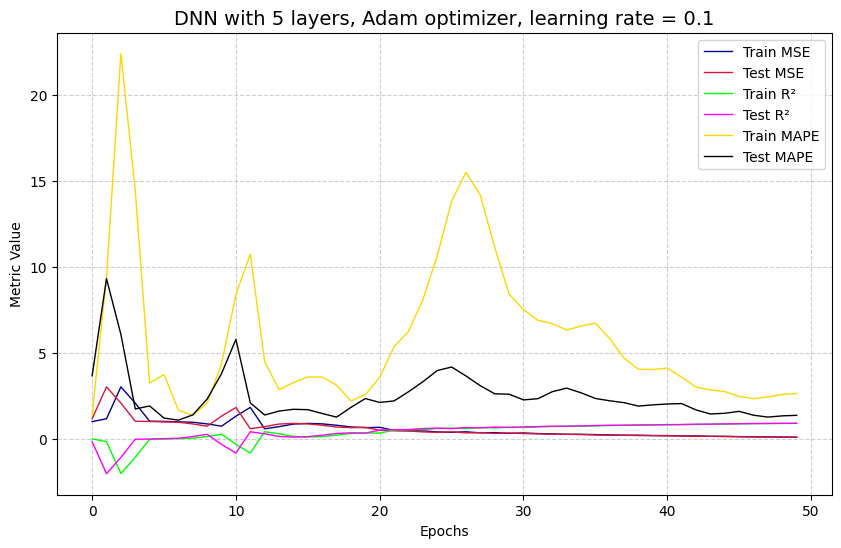

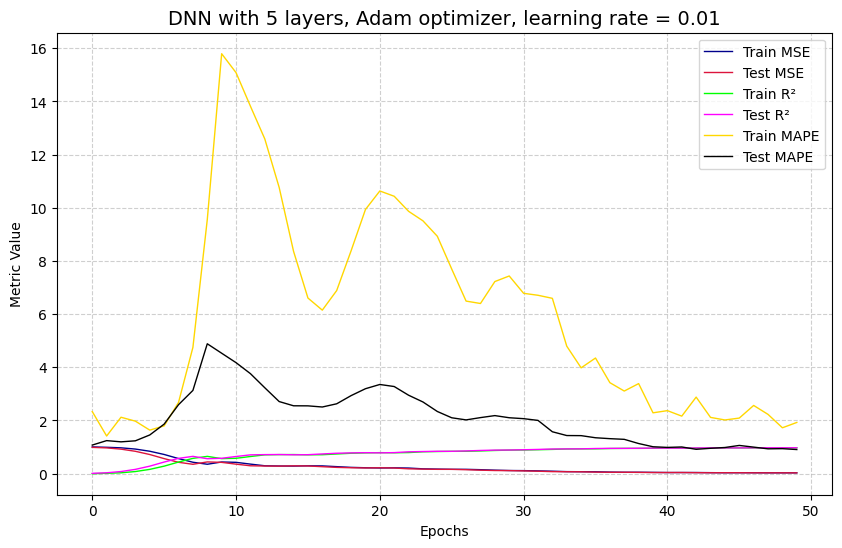

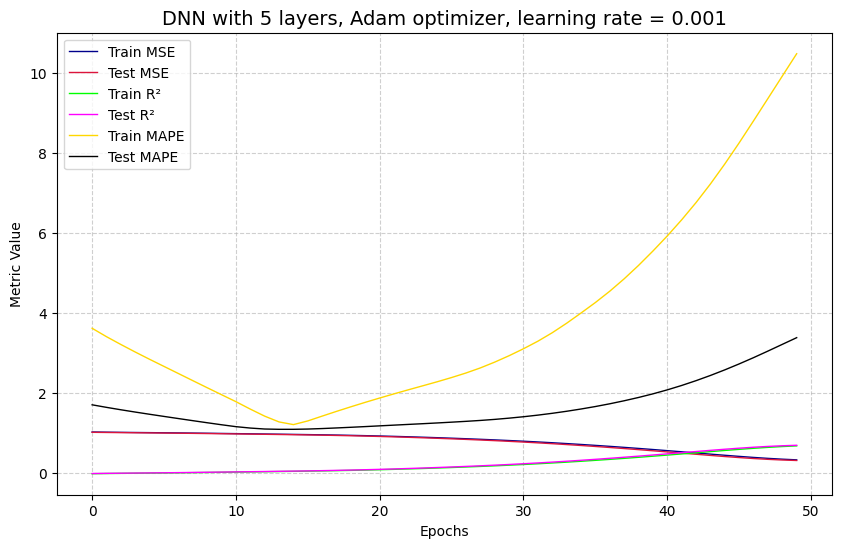

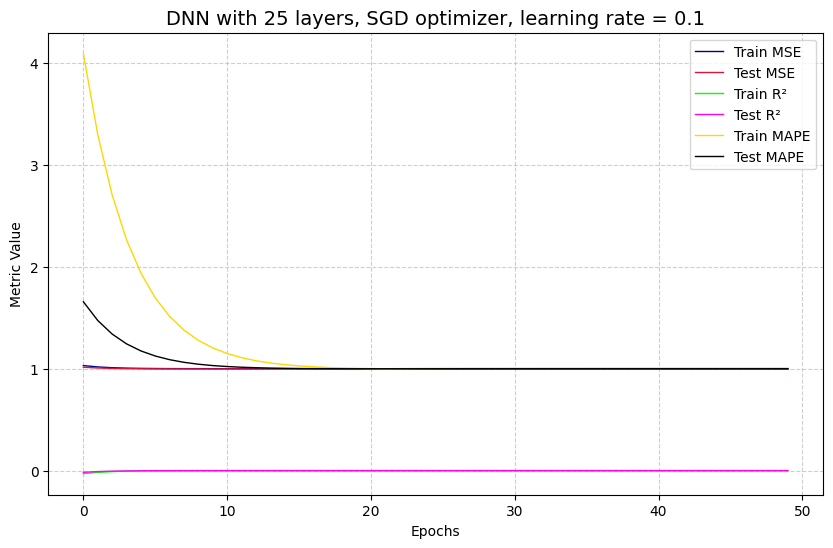

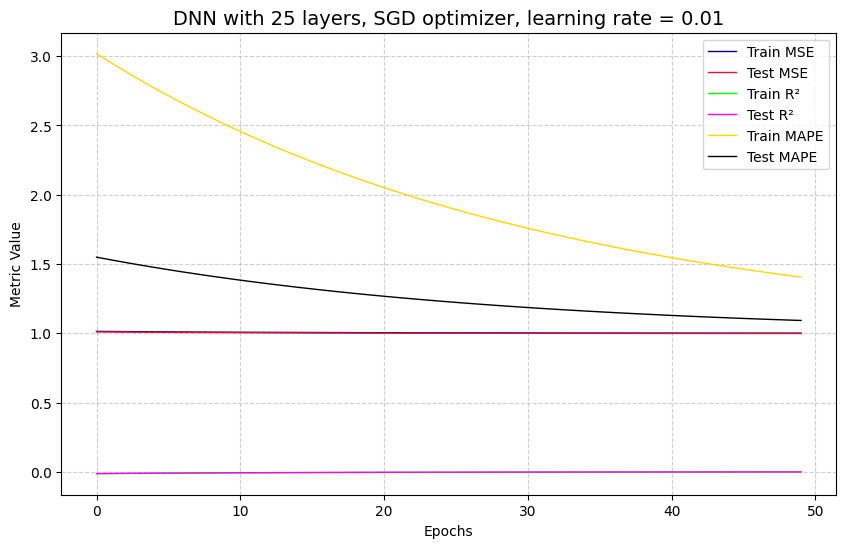

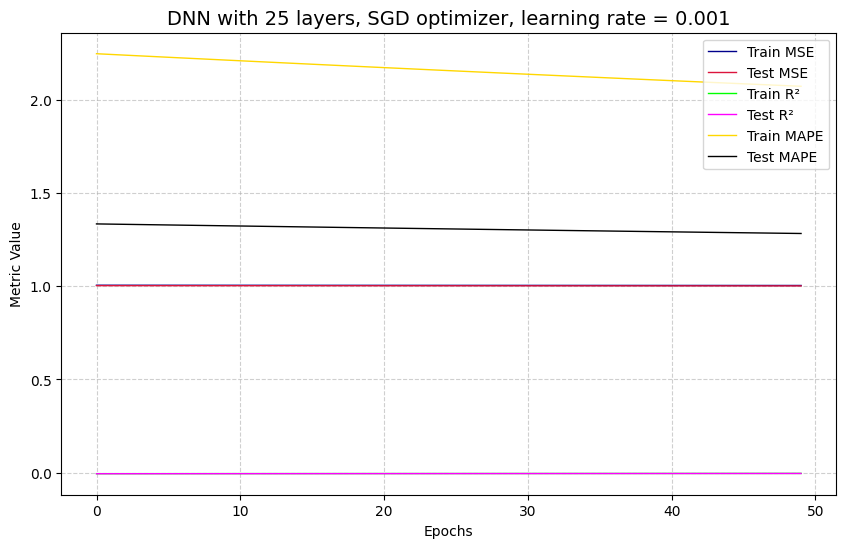

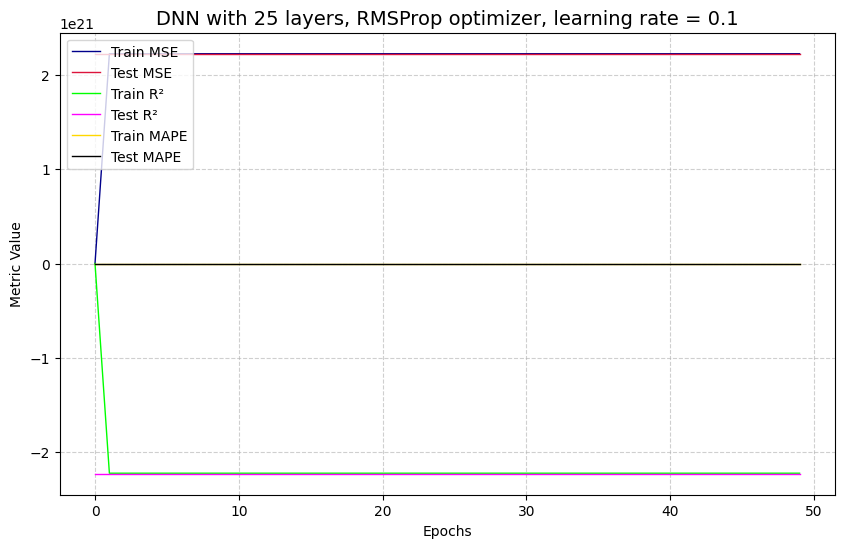

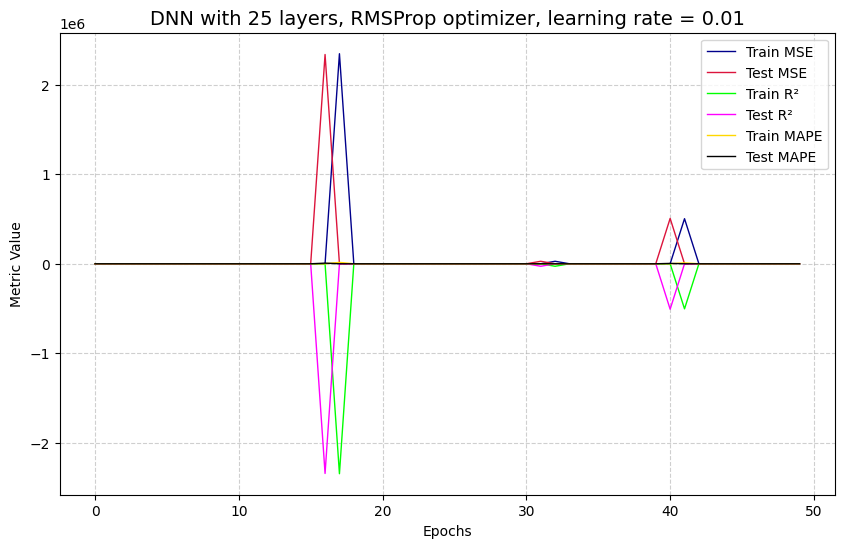

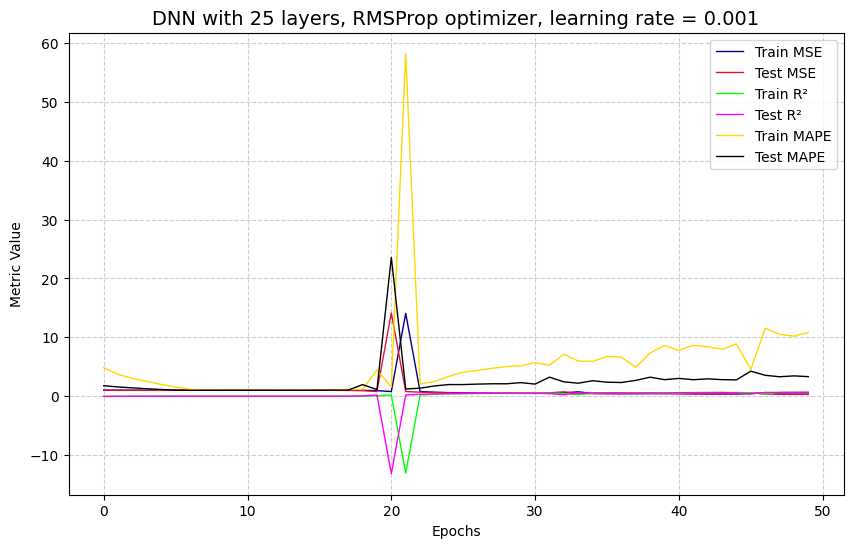

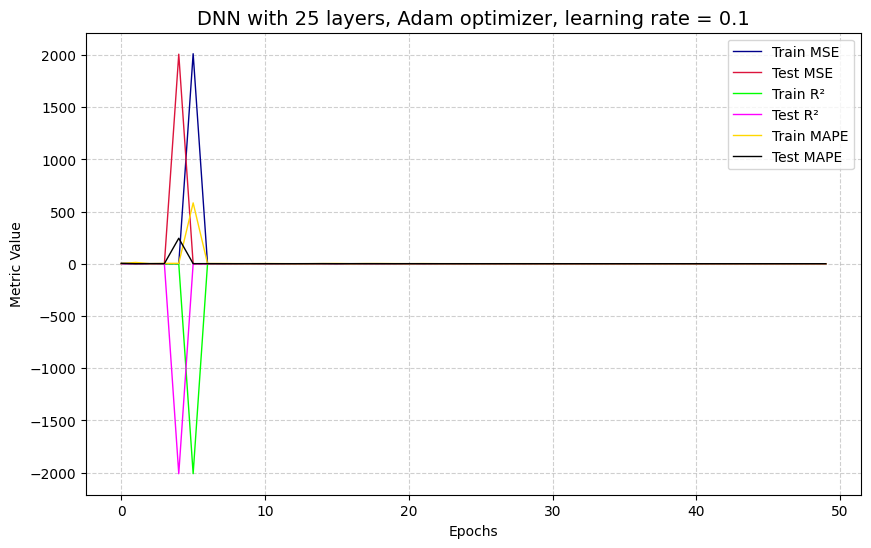

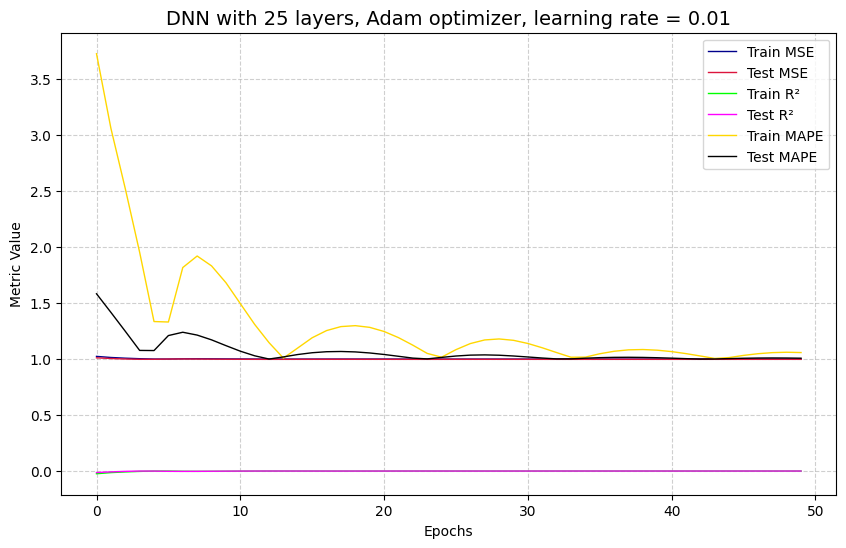

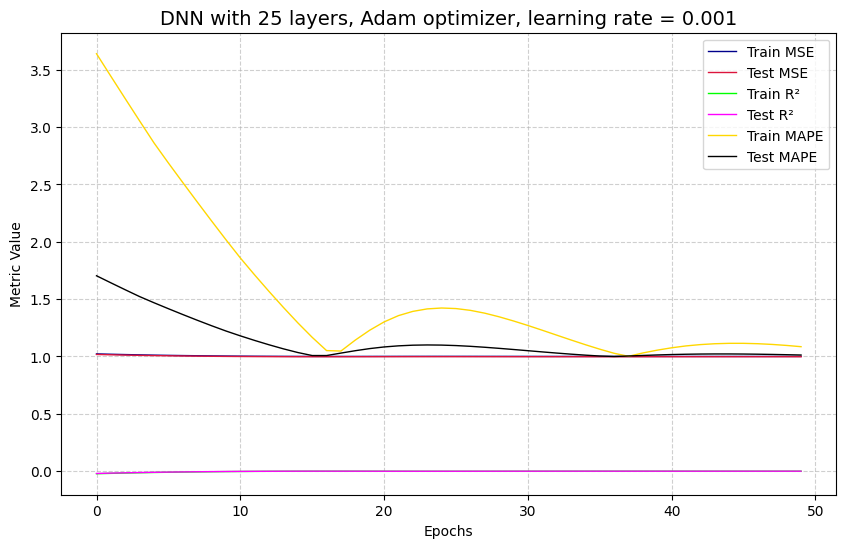

In [59]:
#Plot the results 

for layers in layer_configs:
    for optimizer in optimizers:
        for lr in learning_rates:
    
            train_mse, test_mse, train_r2, test_r2, train_mape, test_mape = results[(tuple(layers), optimizer, lr)]

            title = f"DNN with {len(layers)} layers, {optimizer} optimizer, learning rate = {lr}"
          
            plt.figure(figsize=(10, 6))
            plt.title(title, fontsize=14)
            
            plt.plot(train_mse, label='Train MSE', color='darkblue', linewidth=1)
            plt.plot(test_mse, label='Test MSE', color='crimson', linewidth=1)
            plt.plot(train_r2, label='Train R²', color='lime', linewidth=1)
            plt.plot(test_r2, label='Test R²', color='magenta', linewidth=1)
            plt.plot(train_mape, label='Train MAPE', color='gold', linewidth=1)
            plt.plot(test_mape, label='Test MAPE', color='black', linewidth=1)
        
            plt.xlabel("Epochs")
            plt.ylabel("Metric Value")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            
            plt.show()


In [ ]:
#Show result in table 

import pandas as pd

table_data = []

for layers in layer_configs:
    for optimizer in optimizers:
        for lr in learning_rates:
    
            train_mse, test_mse, train_r2, test_r2, train_mape, test_mape = results[(tuple(layers), optimizer, lr)]

            last_epoch = len(train_mse) - 1

            table_data.append({
                "Layers": len(layers),
                "Optimizer": optimizer,
                "Learning Rate": lr,
                "Train MSE": train_mse[last_epoch],
                "Test MSE": test_mse[last_epoch],
                "Train R²": train_r2[last_epoch],
                "Test R²": test_r2[last_epoch],
                "Train MAPE": train_mape[last_epoch],
                "Test MAPE": test_mape[last_epoch]
            })

df = pd.DataFrame(table_data)

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000) 
print(df)


    Layers Optimizer  Learning Rate     Train MSE      Test MSE      Train R²       Test R²    Train MAPE     Test MAPE
0        1       SGD          0.100  2.163074e-01  2.142836e-01  7.837995e-01  7.852908e-01  7.236159e+00  2.634238e+00
1        1       SGD          0.010  6.683407e-01  6.631916e-01  3.319896e-01  3.354913e-01  3.329449e+00  1.803274e+00
2        1       SGD          0.001  8.690113e-01  8.654304e-01  1.314181e-01  1.328508e-01  3.989888e+00  1.748024e+00
3        1   RMSProp          0.100  1.765179e-01  1.760979e-01  8.235693e-01  8.235524e-01  3.463662e+00  2.399001e+00
4        1   RMSProp          0.010  7.683584e-02  7.741825e-02  9.232022e-01  9.224280e-01  3.552052e+00  1.595632e+00
5        1   RMSProp          0.001  2.171378e-01  2.150655e-01  7.829695e-01  7.845073e-01  5.422557e+00  2.323721e+00
6        1      Adam          0.100  1.686283e-02  1.600124e-02  9.831455e-01  9.839670e-01  1.786703e+00  7.530840e-01
7        1      Adam          0.010  1.0

Conclusions

1. What models and combinations of hyper-parameters worked best? Why?

Layer 1, Adam Optimizer, Learning Rate 0.100:

Train MSE: 0.01174
Test MSE: 0.01068
Train R²: 0.9883
Test R²: 0.9893
Train MAPE: 2.168
Test MAPE: 0.6504

It achieved the low MSE values on both the training and test sets, indicating high accuracy and minimal error. It achieved very high R² scores (close to 1), showing that the model explained almost all of the variance in the data, both in training and testing. The MAPE values were also low, demonstrating that the model made highly accurate predictions with relatively low errors in percentage terms.

2. Influence of optimizer?

SGD struggles with low learning rates, performs okay at 0.1. RMSProp is more stable than SGD, but can be unstable at times. Adam is best overall, especially at higher learning rates (0.1 and 0.01).

3. Influence of learning rate?

0.1 is best for Adam, decent for SGD and RMSProp. 0.01 caused slight drop in performance for all optimizers. In 0.001 performance decreases, but Adam still performs best.

4. Influence of DNN architecture (number of layers)?

More layers (5 or 25) don't improve performance much; results are similar to the 1-layer model

5. Influence of data distribution (linear or non-linear?)

The Friedman dataset has non-linear relationships, and the model's ability to achieve high R² scores and low MSE values suggests it successfully captured these non-linear patterns. This indicates that the chosen architecture (even with a single layer) and the Adam optimizer helped in modeling the non-linear nature of the data effectively.